In [14]:
import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Just to reset the graph such that it is possible to rerun this in a
# Jupyter cell without resetting the whole kernel.
tf.reset_default_graph()
# Set a seed to ensure getting the same results from every run
tf.set_random_seed(4155)

Nx = 10
x_np = np.linspace(0,1,Nx)
Nt = 10
t_np = np.linspace(0,1,Nt)
X,T = np.meshgrid(x_np, t_np)
x = X.ravel()
t = T.ravel()
## The construction phase
zeros = tf.reshape(tf.convert_to_tensor(np.zeros(x.shape)),shape=(-1,1))
x = tf.reshape(tf.convert_to_tensor(x),shape=(-1,1))
t = tf.reshape(tf.convert_to_tensor(t),shape=(-1,1))
points = tf.concat([x,t],1)
num_iter = 100000
num_hidden_neurons = [90]
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)

with tf.variable_scope('dnn'):
    num_hidden_layers = np.size(num_hidden_neurons)
    previous_layer = points
    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer
    dnn_output = tf.layers.dense(previous_layer, 1)
    
def u(x):
    return tf.sin(np.pi*x)
def v(x):
    return -np.pi*tf.sin(np.pi*x)

with tf.name_scope('loss'):
    g_trial = (1 - t**2)*u(x) + t*v(x) + x*(1-x)*t**2*dnn_output
    g_trial_d2t = tf.gradients(tf.gradients(g_trial,t),t)
    g_trial_d2x = tf.gradients(tf.gradients(g_trial,x),x)
    loss = tf.losses.mean_squared_error(zeros, g_trial_d2t[0] - g_trial_d2x[0])
    
learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    traning_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
g_analytic = tf.sin(np.pi*x)*tf.cos(np.pi*t) - tf.sin(np.pi*x)*tf.sin(np.pi*t)
g_dnn = None

## The execution phase
with tf.Session() as sess:
    init.run()
    for i in range(num_iter):
        sess.run(traning_op)
        # If one desires to see how the cost function behaves during training
        #if i % 100 == 0:
        #print(loss.eval())
    g_analytic = g_analytic.eval()
    g_dnn = g_trial.eval()
    
## Compare with the analutical solution
diff = np.abs(g_analytic - g_dnn)
print('Max absolute difference between analytical solution and TensorFlow DNN = %g' % np.max(diff))
G_analytic = g_analytic.reshape((Nt,Nx))
G_dnn = g_dnn.reshape((Nt,Nx))
diff = np.abs(G_analytic - G_dnn)


Max absolute difference between analytical solution and TensorFlow DNN = 0.00581273


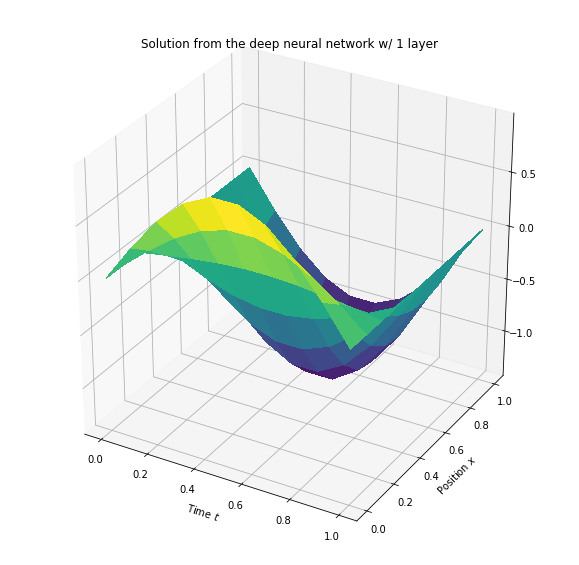

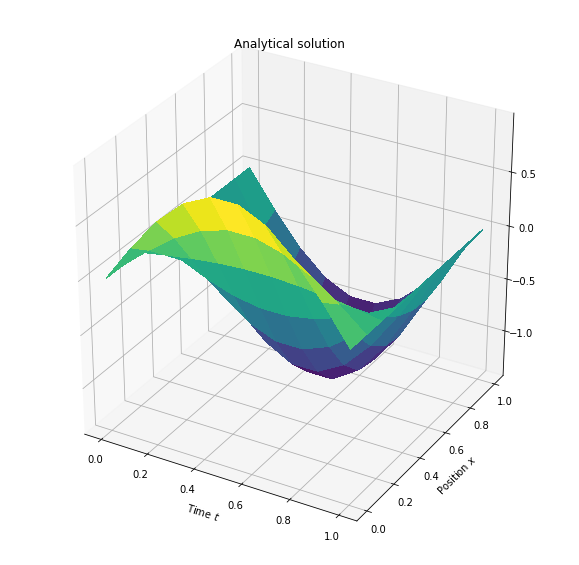

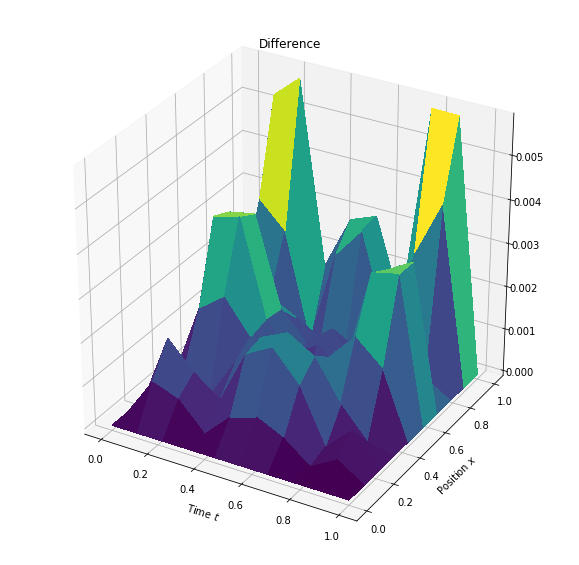

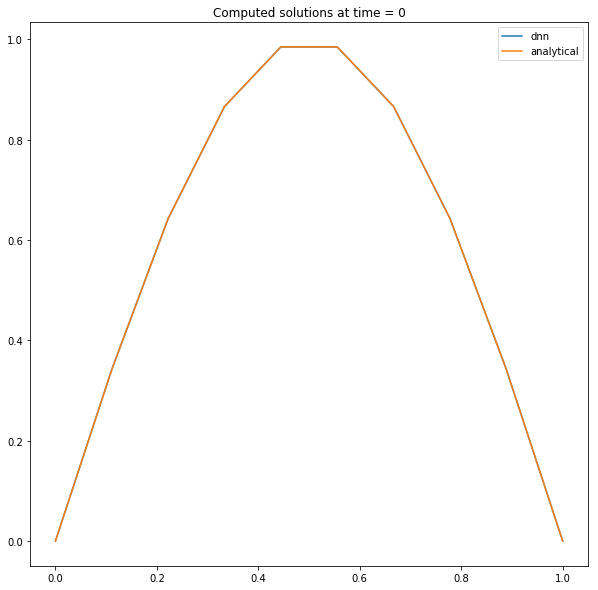

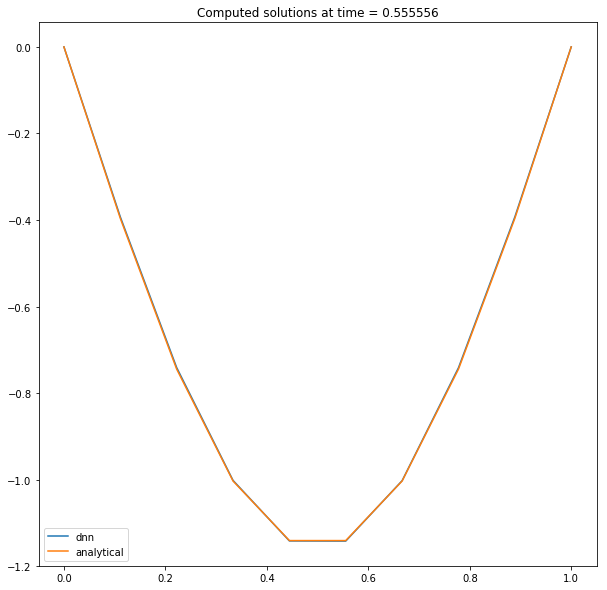

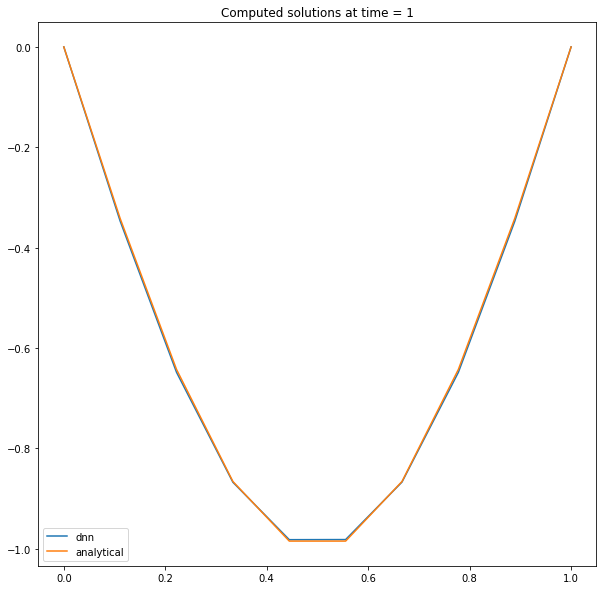

In [15]:
# Plot the results
X,T = np.meshgrid(x_np, t_np)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Solution from the deep neural network w/ %d layer'%len(num_hidden_neurons))
s = ax.plot_surface(X,T,G_dnn,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$');
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Analytical solution')
s = ax.plot_surface(X,T,G_analytic,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$')
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Difference')
s = ax.plot_surface(X,T,diff,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$');
## Take some 3D slices
indx1 = 0
indx2 = int(Nt/2)
indx3 = Nt-1
t1 = t_np[indx1]
t2 = t_np[indx2]
t3 = t_np[indx3]
# Slice the results from the DNN
res1 = G_dnn[indx1,:]
res2 = G_dnn[indx2,:]
res3 = G_dnn[indx3,:]
# Slice the analytical results
res_analytical1 = G_analytic[indx1,:]
res_analytical2 = G_analytic[indx2,:]
res_analytical3 = G_analytic[indx3,:]
# Plot the slices
plt.figure(figsize=(10,10))
plt.title("Computed solutions at time = %g"%t1)
plt.plot(x_np, res1)
plt.plot(x_np,res_analytical1)
plt.legend(['dnn','analytical'])
plt.figure(figsize=(10,10))
plt.title("Computed solutions at time = %g"%t2)
plt.plot(x_np, res2)
plt.plot(x_np,res_analytical2)
plt.legend(['dnn','analytical'])
plt.figure(figsize=(10,10))
plt.title("Computed solutions at time = %g"%t3)
plt.plot(x_np, res3)
plt.plot(x_np,res_analytical3)
plt.legend(['dnn','analytical'])
plt.show()